In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
from torch.utils.data import DataLoader,Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
from torch import nn
import cv2
import os
import glob
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import torchvision
import itertools
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set_theme()

## Loading data

In [3]:
#!unzip '/content/drive/MyDrive/dataset2.zip'

## Reading data

In [4]:
cele_data=pd.read_csv("/content/drive/MyDrive/task1.csv")
cele_data.rename({'image_1': 'image_A', 'image_2': 'image_B','is_match': 'is_Similar','label1':	'label_A','label2':	'label_B'}, axis=1, inplace=True)

cele_data.head()

,image_A,image_B,is_Similar,label_A,label_B
0,032486.jpg,032486.jpg,1,14/032486.jpg,14/032486.jpg
1,032486.jpg,041293.jpg,1,14/032486.jpg,14/041293.jpg
2,032486.jpg,044192.jpg,1,14/032486.jpg,14/044192.jpg
3,032486.jpg,051809.jpg,1,14/032486.jpg,14/051809.jpg
4,032486.jpg,052645.jpg,1,14/032486.jpg,14/052645.jpg


In [5]:
len(cele_data[cele_data['is_Similar']==1]),len(cele_data[cele_data['is_Similar']==0]),len(cele_data)


(90000, 89100, 179100)

## Split Data

In [6]:
train_set,val_set=train_test_split(cele_data,test_size=0.10)
val_set,test_set=train_test_split(val_set,test_size=0.10)
train_set.shape,val_set.shape,test_set.shape

((161190, 5), (16119, 5), (1791, 5))

# Loading Images from folder

In [7]:
class ImageDataset(Dataset):
  def __init__(self,csv,path,transform):
    self.csv=csv
    self.transform=transform
    self.path=path  
    self.image1=self.csv[:]['label_A']
    self.image2=self.csv[:]['label_B']
    self.labels=np.array(self.csv.drop(['image_A', 'image_B','label_A', 'label_B'], axis=1))
  def __len__(self):
    return len(self.image1)
  def __getitem__(self,index): 
    im1=cv2.imread(self.path+self.image1.iloc[index])
    im1=cv2.cvtColor(im1,cv2.COLOR_BGR2RGB)
    im2=cv2.imread(self.path+self.image2.iloc[index])
    im2=cv2.cvtColor(im2,cv2.COLOR_BGR2RGB)
    im1=self.transform(im1)
    im2=self.transform(im2)
    target=self.labels[index]
    sam = {'image_A': im1,'image_B': im2,'labels':target}
 
    return sam

In [8]:
path = '/content/dataset2/'

## Transforming data

In [9]:
def Transformation(path):
        train_transform = transforms.Compose([ transforms.ToPILImage(), transforms.Resize((64,64)),
                        transforms.ToTensor()])
        
        transform =transforms.Compose([transforms.ToPILImage(),transforms.Resize((64,64)),
                        transforms.ToTensor()])
        
        train_dataset=ImageDataset(train_set,path,train_transform)
        val_dataset=ImageDataset(val_set,path,transform)
        test_dataset=ImageDataset(test_set,path,transform)
        train_dataloader = DataLoader(train_dataset, batch_size=32,shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
        test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

        return train_dataloader,val_dataloader,test_dataloader 

In [10]:
train_loader,val_loader,test_loader=Transformation(path)
train_loader,val_loader,test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f1fb93d8fd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f1fb8369690>)

## Normalizing Data

In [11]:
def Normalization(train_loader):
        mean = 0.
        std = 0.
        for train_images in train_loader:
            batch_samples = train_images['image_A'].size(0) # batch size (the last batch can have smaller size!)
            image1 = train_images['image_A'].view(batch_samples,train_images['image_A'].size(1), -1)
            mean += image1.mean(2).sum(0)
            std += image1.std(2).sum(0)

        mean /= len(train_loader.dataset)
        std /= len(train_loader.dataset)
        return mean,std

In [12]:
"""mean,std=Normalization(val_loader)
mean,std"""

'mean,std=Normalization(val_loader)\nmean,std'

## Data Representation

In [13]:
def ShowImage(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

### Training Data


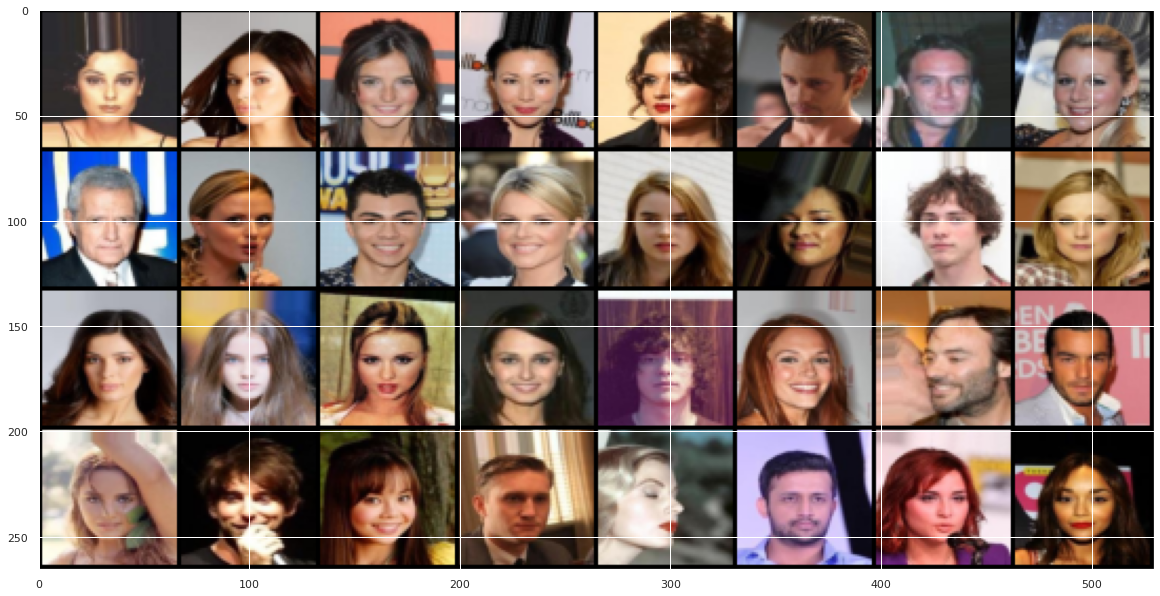

In [14]:
train_images = next(iter(train_loader))
image1, image2, label = train_images
output = torchvision.utils.make_grid(train_images['image_A'])
ShowImage(output)

### Testing Data

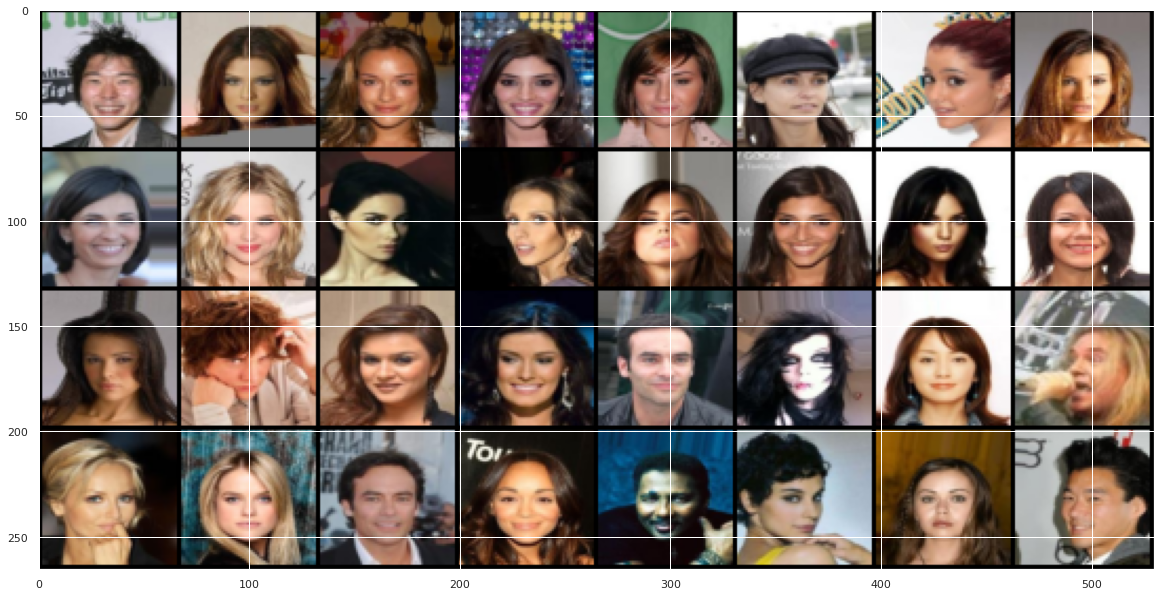

In [15]:
test_images = next(iter(test_loader))
output2 = torchvision.utils.make_grid(test_images['image_A'])
ShowImage(output2)

## Network

In [16]:
class Face_verification(nn.Module):
    def __init__(self):
        super( Face_verification, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16,32, 5, stride=2, padding=1)
        
        self.fc1 = nn.Linear(1568,1024)  
        self.fc2 = nn.Linear(1024,512)  
        self.fc3 = nn.Linear(512, 1)  

    def forward(self, x1,x2):
        d=(x1-x2)**2
        x = self.pool(F.relu(self.conv1(d)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
lr=0.001
model = Face_verification()
optimizer = optim.NAdam(model.parameters(), lr=lr)
loss_func = nn.BCEWithLogitsLoss()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_func = loss_func.to(device)
print(model)

Face_verification(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)


## Training Model

In [18]:
def binary_acc(y_pred, y_test):
    for i in range(len(y_pred)):
       if y_pred[i] > 0.5:
           y_pred[i]=1
       else:
           y_pred[i]=0
    acc = (y_pred == y_test).sum()
    return  acc

In [19]:
def train(net, train_loader, val_loader,epochs, loss_func, optimizer):
  trainn_loss = []
  train_accuracy = []
  vali_loss = []
  vali_accuracy = []
  for epoch in range(epochs):
    correct = 0
    total = 0
    correct_val = 0
    train_loss = 0
    val_loss = 0
    total_val = 0
    for i, data in enumerate(train_loader, 0):
      im1,im2, labels = Variable(data['image_A']), Variable(data['image_B']), Variable(data['labels'])
      im1,im2,labels=im1.to(device),im2.to(device),labels.to(device)
      optimizer.zero_grad()
      outs = net(im1, im2)
      loss = loss_func(outs.float(),labels.float())
      loss.backward()
      optimizer.step()
      total += len(labels)
      correct += binary_acc(outs,labels)
      train_loss += loss.item()
    accuracy = 100 * correct / float(total)
    trainn_loss.append(train_loss/len(train_loader))
    train_accuracy.append(accuracy)
    print('Epoch: {}\n  Training Loss: {}\n Training Accuracy: {}% \n'.format(epoch, train_loss/len(train_loader), accuracy))
    for j, data in enumerate(val_loader, 0):
      #print(j)
      im1, im2, labels2 = Variable(data['image_A']), Variable(data['image_B']), Variable(data['labels'])
      im1,im2,labels2=im1.to(device),im2.to(device),labels2.to(device)
      val_out = net(im1, im2)
      loss = loss_func(val_out.float(),labels2.float())
      total_val += len(labels2)
      correct_val += binary_acc(val_out,labels2)
      val_loss += loss.item()
    accuracy_val = 100 * correct_val / float(total_val)
    vali_loss.append(val_loss/len(val_loader))
    vali_accuracy.append(accuracy_val)
  
    print('Epoch: {}\n Validation Loss: {}\n Validation Accuracy: {} %\n \n___________'.format(epoch, val_loss/len(val_loader), accuracy_val))
 
  return net, trainn_loss, train_accuracy, vali_loss, vali_accuracy

In [20]:
model, train_loss, train_acc, val_loss, valid_acc = train(model,train_loader, val_loader,10, loss_func, optimizer)

Epoch: 0
  Training Loss: 0.5568144243771048
 Training Accuracy: 67.40554809570312% 

Epoch: 0
 Validation Loss: 0.5062149702793076
 Validation Accuracy: 74.2850112915039 %
 
___________
Epoch: 1
  Training Loss: 0.42986753873701555
 Training Accuracy: 77.85967254638672% 

Epoch: 1
 Validation Loss: 0.40432046891914475
 Validation Accuracy: 80.99137878417969 %
 
___________
Epoch: 2
  Training Loss: 0.29496055258324855
 Training Accuracy: 86.47000885009766% 

Epoch: 2
 Validation Loss: 0.322878645999091
 Validation Accuracy: 84.8812026977539 %
 
___________
Epoch: 3
  Training Loss: 0.1860666815842213
 Training Accuracy: 92.08077239990234% 

Epoch: 3
 Validation Loss: 0.2905497239710438
 Validation Accuracy: 88.36776733398438 %
 
___________
Epoch: 4
  Training Loss: 0.11944927925747902
 Training Accuracy: 95.19449615478516% 

Epoch: 4
 Validation Loss: 0.288125217792445
 Validation Accuracy: 90.20410919189453 %
 
___________
Epoch: 5
  Training Loss: 0.0799923004455572
 Training Accur

## Saving Model

In [32]:
PATH = './task_CNNtask1exp2.pth'
torch.save(model.state_dict(), PATH)

## Loading Model

In [33]:
model = Face_verification()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing Model

In [34]:
def testpredictions(y_pred):
    for i in range(len(y_pred)):
       if y_pred[i] > 0.5:
           y_pred[i]=1
       else:
           y_pred[i]=0
    return y_pred

In [35]:
def Testing_model( model, test_data):
  total=0
  accuracy = 0
  acc=0
  predictions = []
  targets =  []
  for data in test_data:
    im1, im2, labels = data['image_A'], data['image_B'], data['labels']
    with torch.no_grad():
        logps = model(im1,im2)
    pred=testpredictions(logps)
    total += labels.size(0)
    acc += binary_acc(logps,labels)
    labels=labels.detach().cpu().numpy()
    pred=pred.detach().cpu().numpy()
    predictions.append(pred)
    targets.append(labels)
  print('Model Accuracy: {}%\n\n'.format(100 * (acc/total)))
  return predictions,targets
                  
                  

In [36]:
pred, target_labels = Testing_model(model, test_loader)


Model Accuracy: 92.57398223876953%




In [39]:
pred= [item for sublist in  pred for item in sublist]
target_labels = [item for sublist in target_labels for item in sublist]

## Testing Predictions

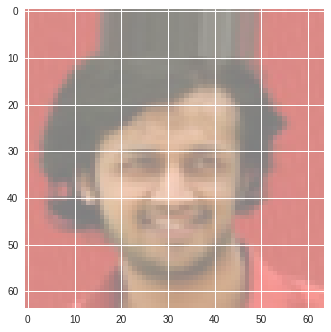

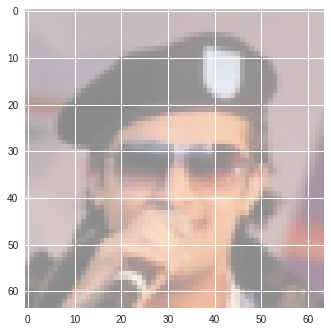

GroundTruth : 1 
 Prediction : 1


In [43]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

test_images = next(iter(test_loader))
img1=test_images['image_A'][0]
img2=test_images['image_B'][0]
label=test_images['labels'][0]

imshow(torchvision.utils.make_grid(img1))
print()
imshow(torchvision.utils.make_grid(img2))

#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(32)))
output=model(img1.view(1, img1.shape[0],img1.shape[1], img1.shape[2]),img2.view(1, img2.shape[0],img2.shape[1], img2.shape[2]))
predicted = testpredictions(output)
#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(32)))
print('GroundTruth : {} \n Prediction : {}'.format(label.item(),int(predicted.item())))


## Visualization

In [44]:
def visualize_plots(epochs,train_loss,train_acc,valid_loss,valid_acc,targets,predictions):
    epochs_= list(range(epochs))
    fig_size = (13, 11)
    fig, axes = plt.subplots(2, 2, figsize=fig_size)

    plt.style.use('seaborn')
    plt.subplot(221)
    plt.plot(epochs_,train_loss)
    plt.title("Epochs Vs Train Loss")   
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss per epoch ")

    plt.style.use('seaborn')
    plt.subplot(222)
    plt.plot(epochs_,train_acc)
    plt.title("Epochs Vs Train Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Train accuracy per epoch for gender")

    plt.subplot(223)
    plt.plot(epochs_,valid_acc)
    plt.title("Epochs Vs Validation Accuracy")   
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy per epoch")

    plt.subplot(224)
    plt.plot(epochs_,valid_loss)
    plt.title("Epochs Vs Validation Loss")   
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss per epoch")

    recall = recall_score(targets,predictions,average='weighted', labels=np.unique(predictions))
    pre = precision_score(targets,predictions,average='weighted', labels=np.unique(predictions))
    f = f1_score(targets,predictions,average='weighted', labels=np.unique(predictions))
    print("Recall:",recall)
    print("Precision:",pre)
    print("F-Score:",f)
  

Recall: 0.9257398101619208
Precision: 0.9285409139465135
F-Score: 0.9255907298958029


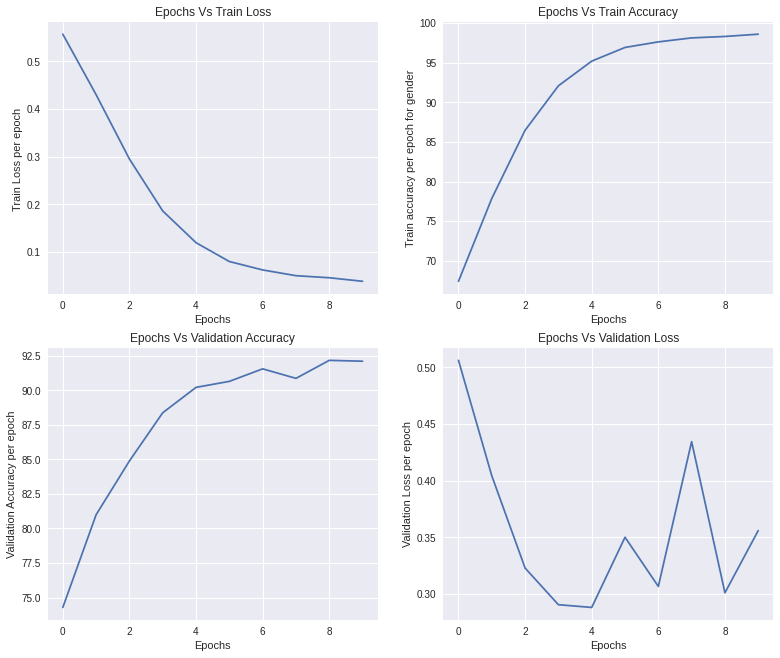

In [45]:
sns.set_style("darkgrid")
visualize_plots(10, train_loss, train_acc, val_loss, valid_acc,target_labels,pred)

## Confusion Matrix

In [46]:
from sklearn.metrics import confusion_matrix,classification_report
def confusion_matrix_plot(targets,predictions):
        cf_matrix = confusion_matrix(targets,predictions)
        plt.figure(figsize = (15,10))
        sns.heatmap(cf_matrix, annot=True)

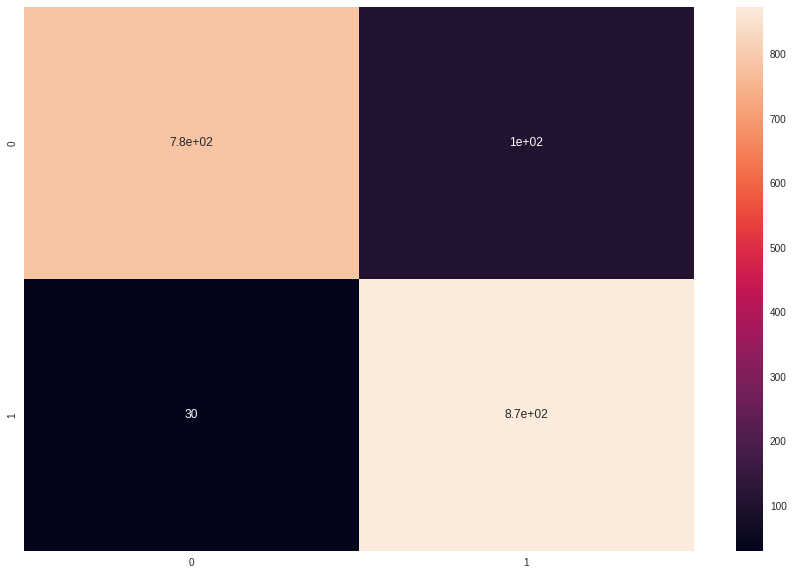

In [47]:
confusion_matrix_plot(target_labels,pred)